In [ ]:
##Starting Lines Of Code For Spark To Work On Google Collab

!python --version

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

import os 
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

!tar xf spark-3.3.1-bin-hadoop3.tgz

!pip install pyspark py4j

!pip install pandas

Python 3.8.16
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 200 kB 61.5 MB/s 
     |████████████████████████████████| 199 kB 18.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=03ebe37586bc2b5c4df85c1229092890227115820c3c7a87dd1e646142baf333
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##All Of The Import Statements

from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import mean_squared_error, mean_squared_log_error,classification_report,confusion_matrix,r2_score

##Initialise Spark Environment
spark = SparkSession.builder.appName("gdptest1").getOrCreate()

In [ ]:
##load dataset in pandas format
dataset = pd.read_csv('/content/countries_gdp.csv')

In [ ]:
##display the first 3 countries in the list(organized alphabetically)
dataset.head(3)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"


In [ ]:
#display information about the dataset

dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

In [ ]:
##load dataset in spark dataframe format
df = spark.read.csv("/content/countries_gdp.csv", header = True, inferSchema =True)
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



In [ ]:

#label columns
dataset.columns = (["country","region","population","area","density","coastline_area_ratio","net_migration","infant_mortality_rate","gdp_per_capita","literacy_rate","telecom","arable","crops","other","climate","birthrate","deathrate","agriculture","industry","service"])


In [ ]:

##modify field typing for the columns
dataset.country = dataset.country.astype('category')
dataset.region = dataset.region.astype('category')

dataset.density = dataset.density.astype(str)
dataset.density = dataset.density.str.replace(",",".").astype(float)

dataset.coastline_area_ratio = dataset.coastline_area_ratio.astype(str)
dataset.coastline_area_ratio = dataset.coastline_area_ratio.str.replace(",",".").astype(float)

dataset.net_migration = dataset.net_migration.astype(str)
dataset.net_migration = dataset.net_migration.str.replace(",",".").astype(float)

dataset.infant_mortality_rate = dataset.infant_mortality_rate.astype(str)
dataset.infant_mortality_rate = dataset.infant_mortality_rate.str.replace(",",".").astype(float)

dataset.literacy_rate = dataset.literacy_rate.astype(str)
dataset.literacy_rate = dataset.literacy_rate.str.replace(",",".").astype(float)

dataset.telecom = dataset.telecom.astype(str)
dataset.telecom = dataset.telecom.str.replace(",",".").astype(float)

dataset.arable = dataset.arable.astype(str)
dataset.arable = dataset.arable.str.replace(",",".").astype(float)

dataset.crops = dataset.crops.astype(str)
dataset.crops = dataset.crops.str.replace(",",".").astype(float)

dataset.other = dataset.other.astype(str)
dataset.other = dataset.other.str.replace(",",".").astype(float)

dataset.climate = dataset.climate.astype(str)
dataset.climate = dataset.climate.str.replace(",",".").astype(float)

dataset.birthrate = dataset.birthrate.astype(str)
dataset.birthrate = dataset.birthrate.str.replace(",",".").astype(float)

dataset.deathrate = dataset.deathrate.astype(str)
dataset.deathrate = dataset.deathrate.str.replace(",",".").astype(float)

dataset.agriculture = dataset.agriculture.astype(str)
dataset.agriculture = dataset.agriculture.str.replace(",",".").astype(float)

dataset.industry = dataset.industry.astype(str)
dataset.industry = dataset.industry.str.replace(",",".").astype(float)

dataset.service = dataset.service.astype(str)
dataset.service = dataset.service.str.replace(",",".").astype(float)



In [ ]:
#display info about the updated dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   country                227 non-null    category
 1   region                 227 non-null    category
 2   population             227 non-null    int64   
 3   area                   227 non-null    int64   
 4   density                227 non-null    float64 
 5   coastline_area_ratio   227 non-null    float64 
 6   net_migration          224 non-null    float64 
 7   infant_mortality_rate  224 non-null    float64 
 8   gdp_per_capita         226 non-null    float64 
 9   literacy_rate          209 non-null    float64 
 10  telecom                223 non-null    float64 
 11  arable                 225 non-null    float64 
 12  crops                  225 non-null    float64 
 13  other                  225 non-null    float64 
 14  climate                205 non-null    flo

In [ ]:
#describe the information of the updated dataset
dataset.describe()

,population,area,density,coastline_area_ratio,net_migration,infant_mortality_rate,gdp_per_capita,literacy_rate,telecom,arable,crops,other,climate,birthrate,deathrate,agriculture,industry,service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

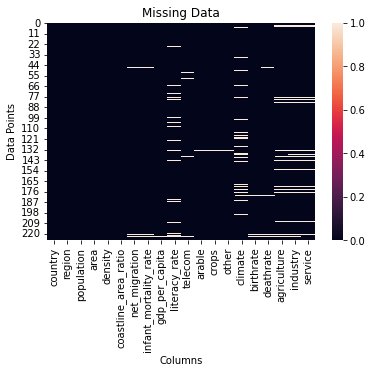

In [ ]:
#find missing data and display it in the form of a heatmap
sns.heatmap(dataset.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

In [ ]:
#fill the missing data

dataset['net_migration'].fillna(0, inplace=True)
dataset['infant_mortality_rate'].fillna(0, inplace=True)
dataset['gdp_per_capita'].fillna(2500, inplace=True)
dataset['literacy_rate'].fillna(dataset.groupby('region')['literacy_rate'].transform('mean'), inplace= True)
dataset['telecom'].fillna(dataset.groupby('region')['telecom'].transform('mean'), inplace= True)
dataset['arable'].fillna(0, inplace=True)
dataset['crops'].fillna(0, inplace=True)
dataset['other'].fillna(0, inplace=True)
dataset['climate'].fillna(0, inplace=True)
dataset['birthrate'].fillna(dataset.groupby('region')['birthrate'].transform('mean'), inplace= True)
dataset['deathrate'].fillna(dataset.groupby('region')['deathrate'].transform('mean'), inplace= True)
dataset['agriculture'].fillna(0.17, inplace=True)
dataset['service'].fillna(0.8, inplace=True)
dataset['industry'].fillna((1 - dataset['agriculture'] - dataset['service']), inplace= True)

In [ ]:
#show which columns still have null values
print(dataset.isnull().sum())

country                  0
region                   0
population               0
area                     0
density                  0
coastline_area_ratio     0
net_migration            0
infant_mortality_rate    0
gdp_per_capita           0
literacy_rate            0
telecom                  0
arable                   0
crops                    0
other                    0
climate                  0
birthrate                0
deathrate                0
agriculture              0
industry                 0
service                  0
dtype: int64


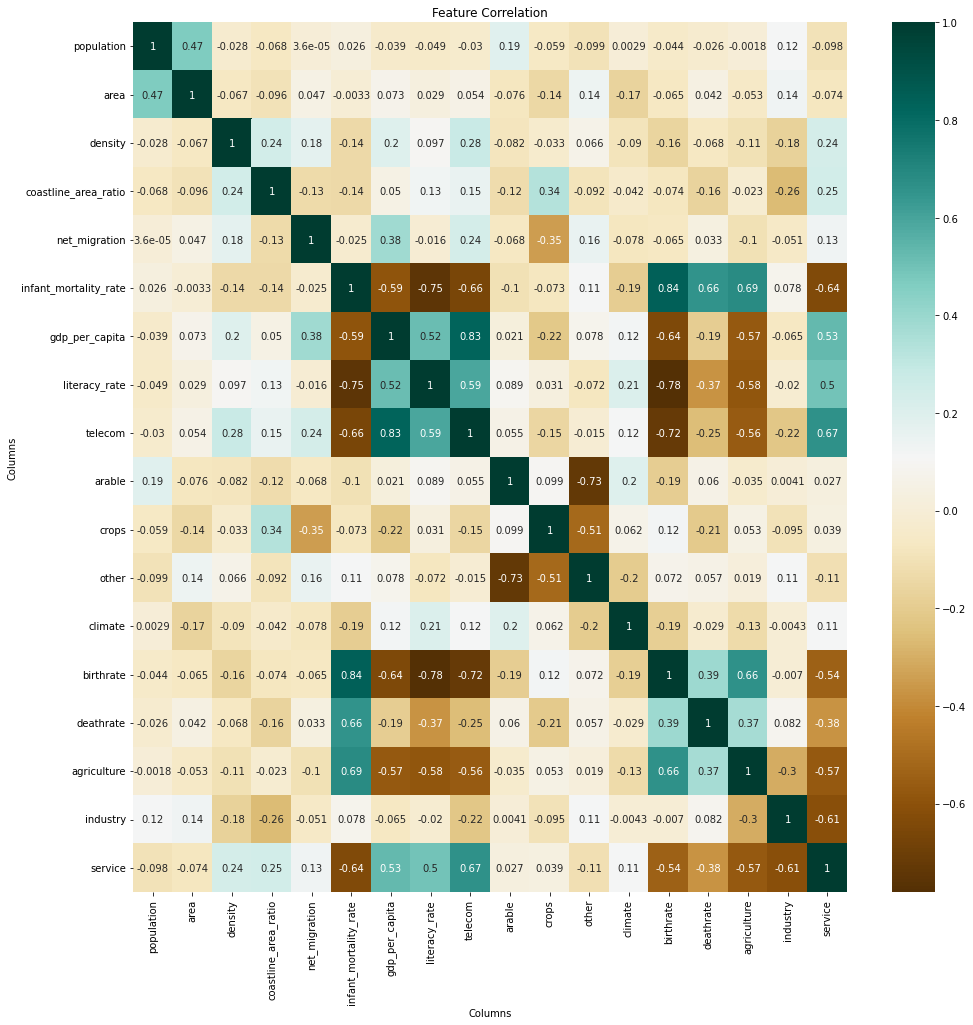

In [ ]:

#display correlation heatmap

fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(dataset.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()


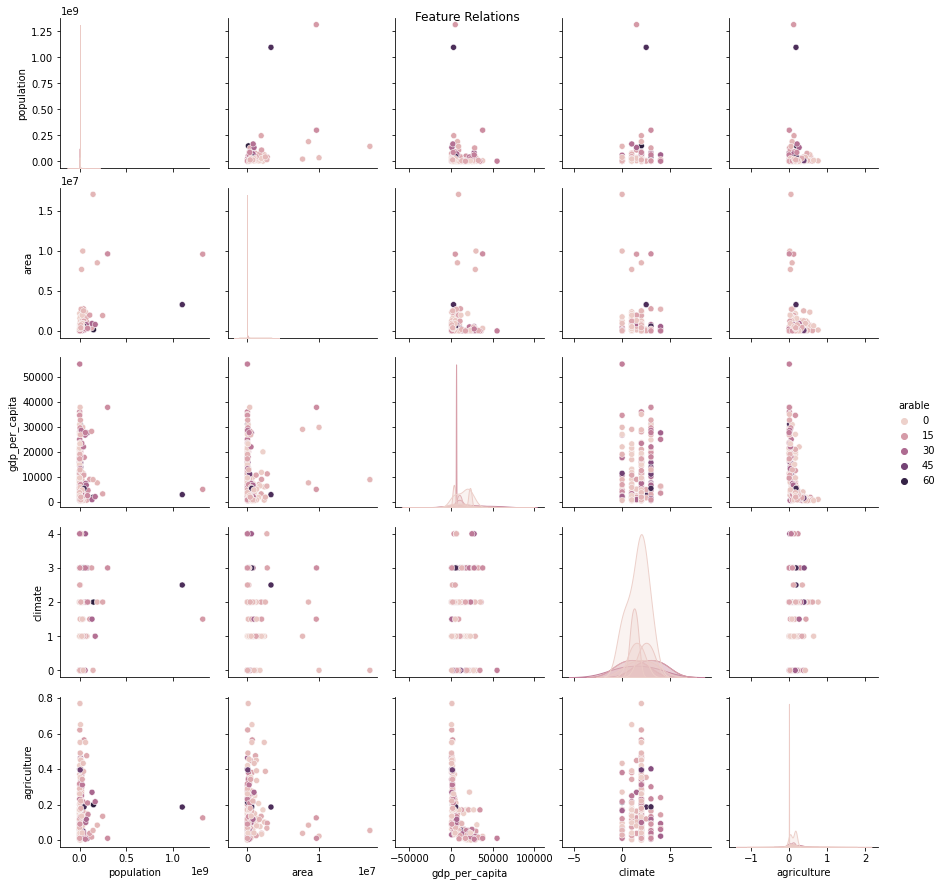

In [ ]:
#show how each field correlates to one another in the form of a feature relation

g = sns.pairplot(dataset[['population', 'area', 'gdp_per_capita', 'climate', 'arable','agriculture']], hue='arable')
g.fig.suptitle('Feature Relations')
plt.show()

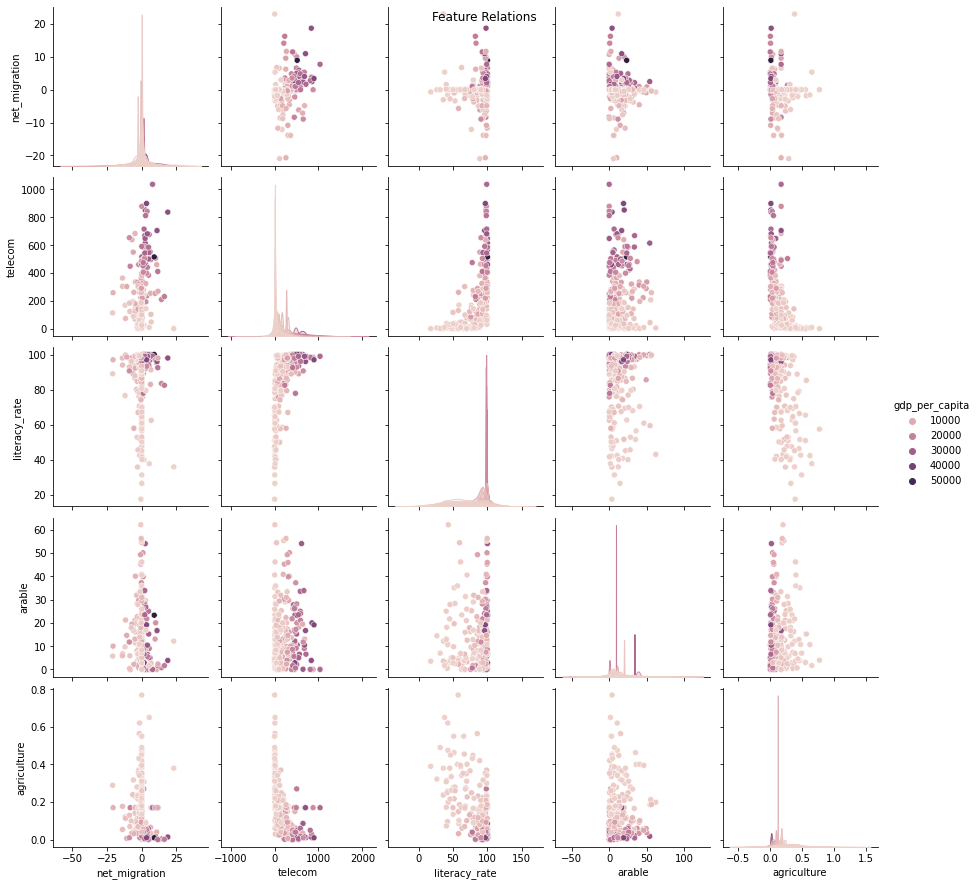

In [ ]:
###show how each field correlates to one another in the form of a feature relation connected to GDP
g = sns.pairplot(dataset[['net_migration', 'telecom', 'literacy_rate', 'arable','agriculture', 'gdp_per_capita']], hue='gdp_per_capita')
g.fig.suptitle('Feature Relations')
plt.show()

<ipython-input-17-5cb2b1348d31>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(1, 1, 1)


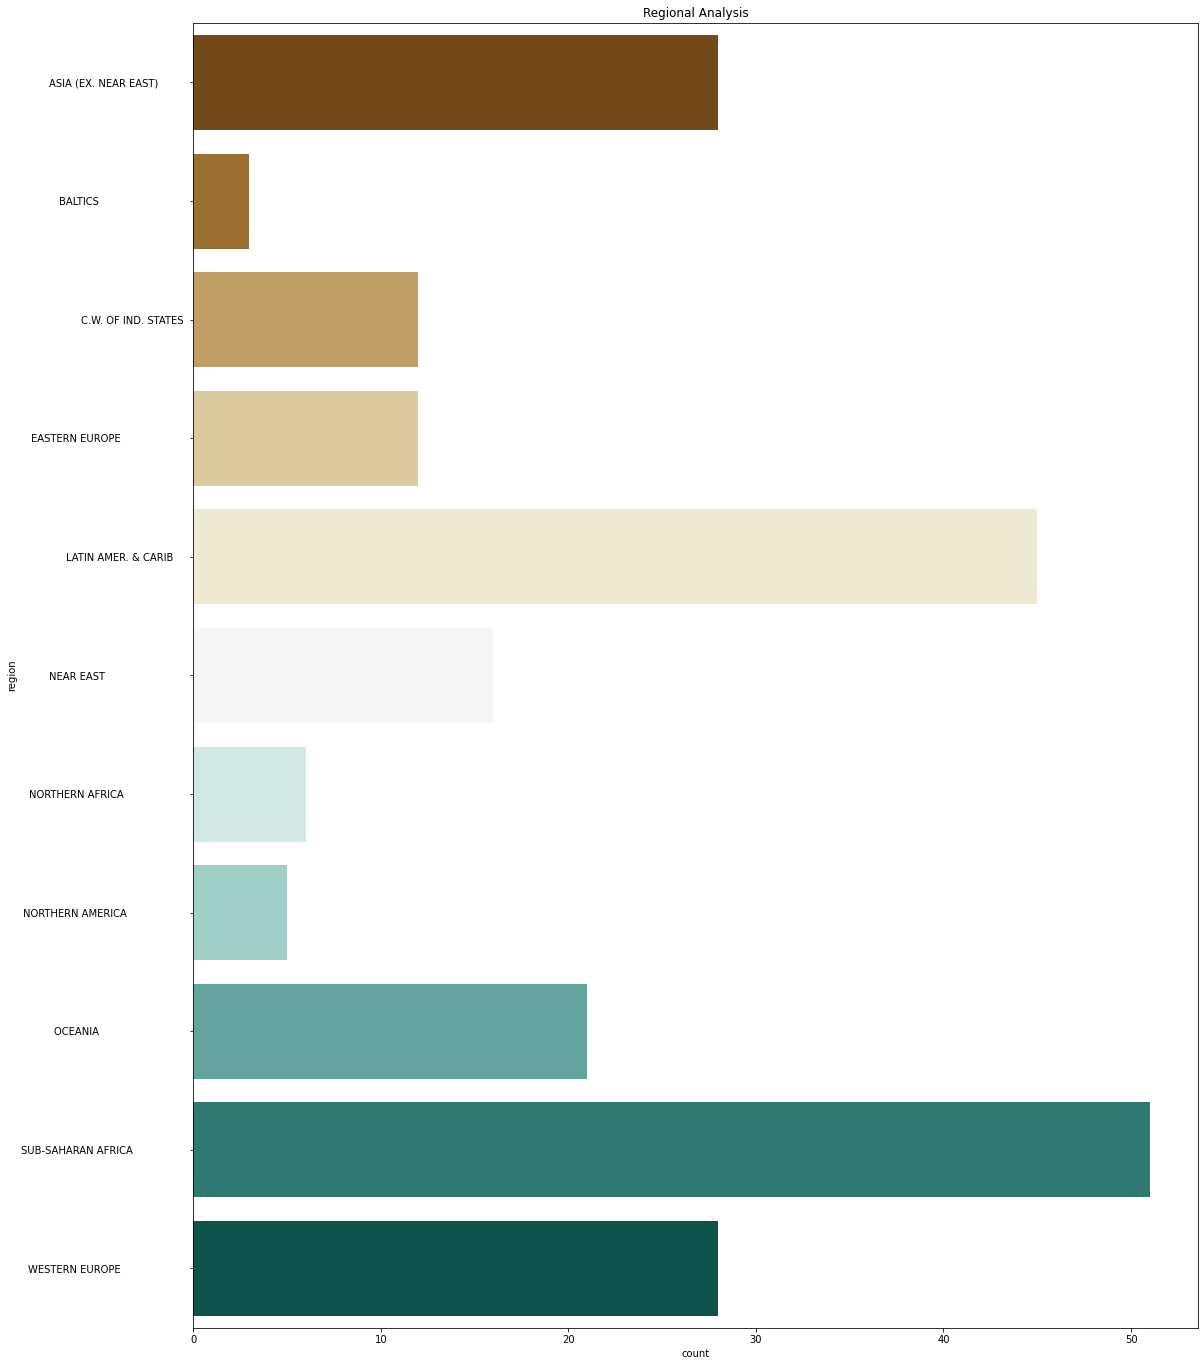

In [ ]:
#show regional analysis in the form of a countplot

fig = plt.figure(figsize=(18, 24))
plt.title('Regional Analysis')
ax1 = fig.add_subplot(1, 1, 1)
sns.countplot(data= dataset, y= 'region', ax= ax1, palette='BrBG')
plt.show()

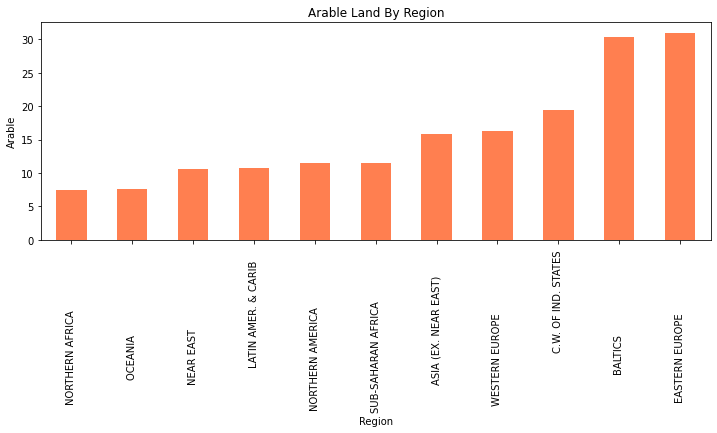

In [ ]:
#arable land analysis by Region
fig = plt.figure(figsize=(12, 4))
dataset.groupby('region')['arable'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('Arable Land By Region')
plt.xlabel("Region")
plt.ylabel('Arable')
plt.show()

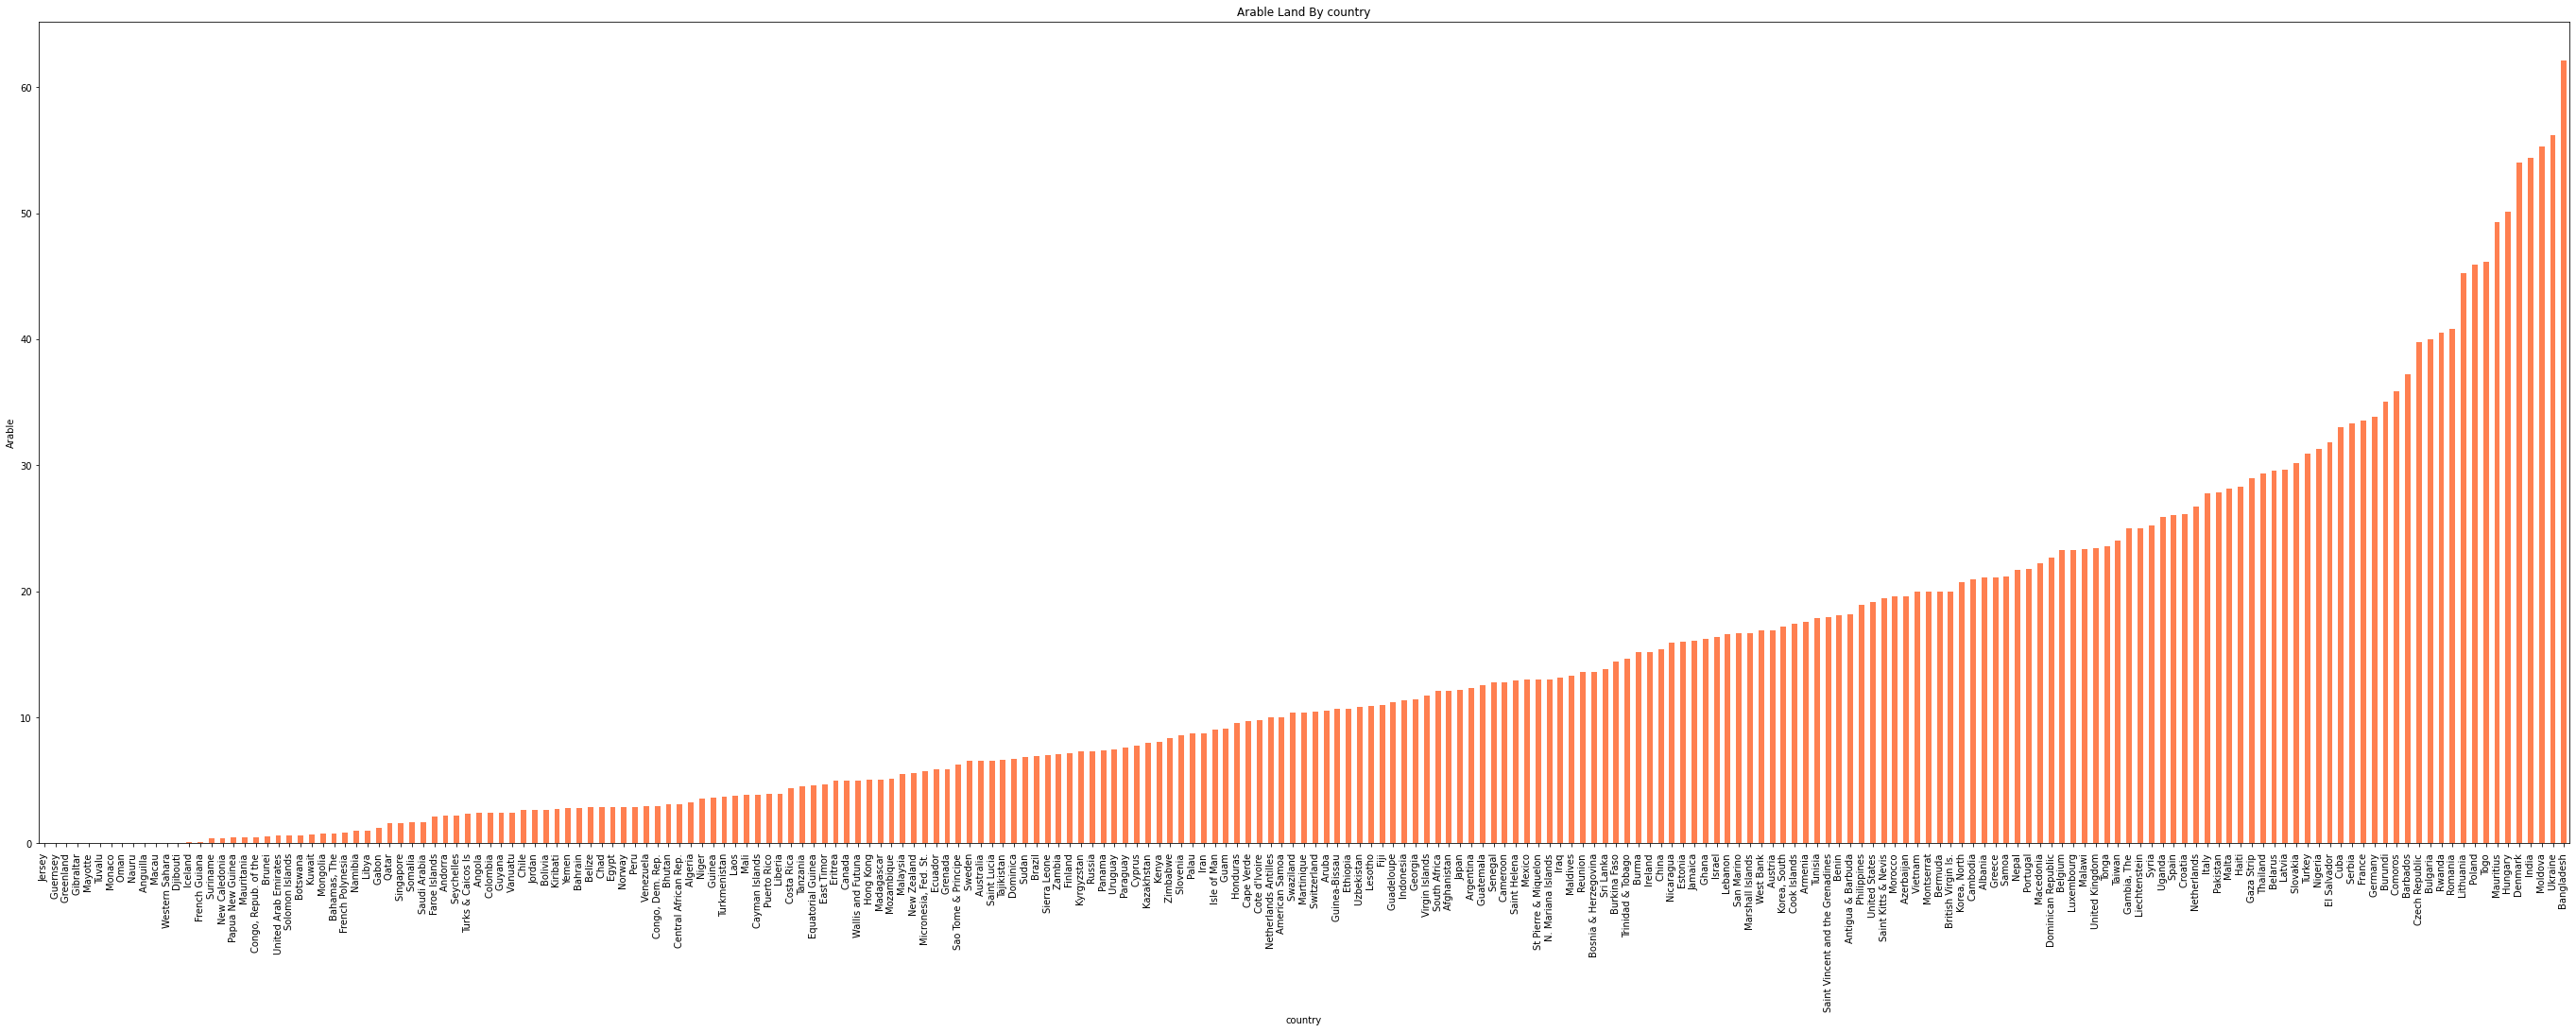

In [ ]:
#arable land analysis by country
fig = plt.figure(figsize=(48, 16))
dataset.groupby('country')['arable'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('Arable Land By country')
plt.xlabel("country")
plt.ylabel('Arable')
plt.show()

In [ ]:
#list of countries with the most arable land
arableData = dataset[["country","arable"]]
arableData.sort_values(by=['arable'],ascending=False)

,country,arable
16,Bangladesh,62.11
211,Ukraine,56.21
137,Moldova,55.30
94,India,54.40
54,Denmark,54.02
...,...,...
104,Jersey,0.00
80,Greenland,0.00
78,Gibraltar,0.00
144,Nauru,0.00


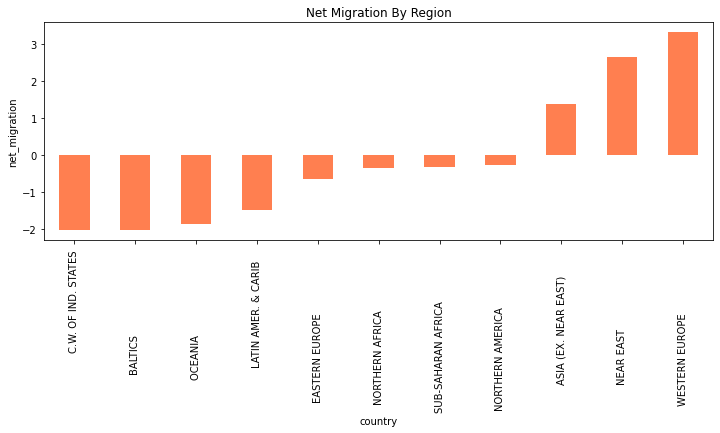

In [ ]:
#net migration analysis by Region
fig = plt.figure(figsize=(12, 4))
dataset.groupby('region')['net_migration'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('Net Migration By Region')
plt.xlabel("country")
plt.ylabel('net_migration')
plt.show()

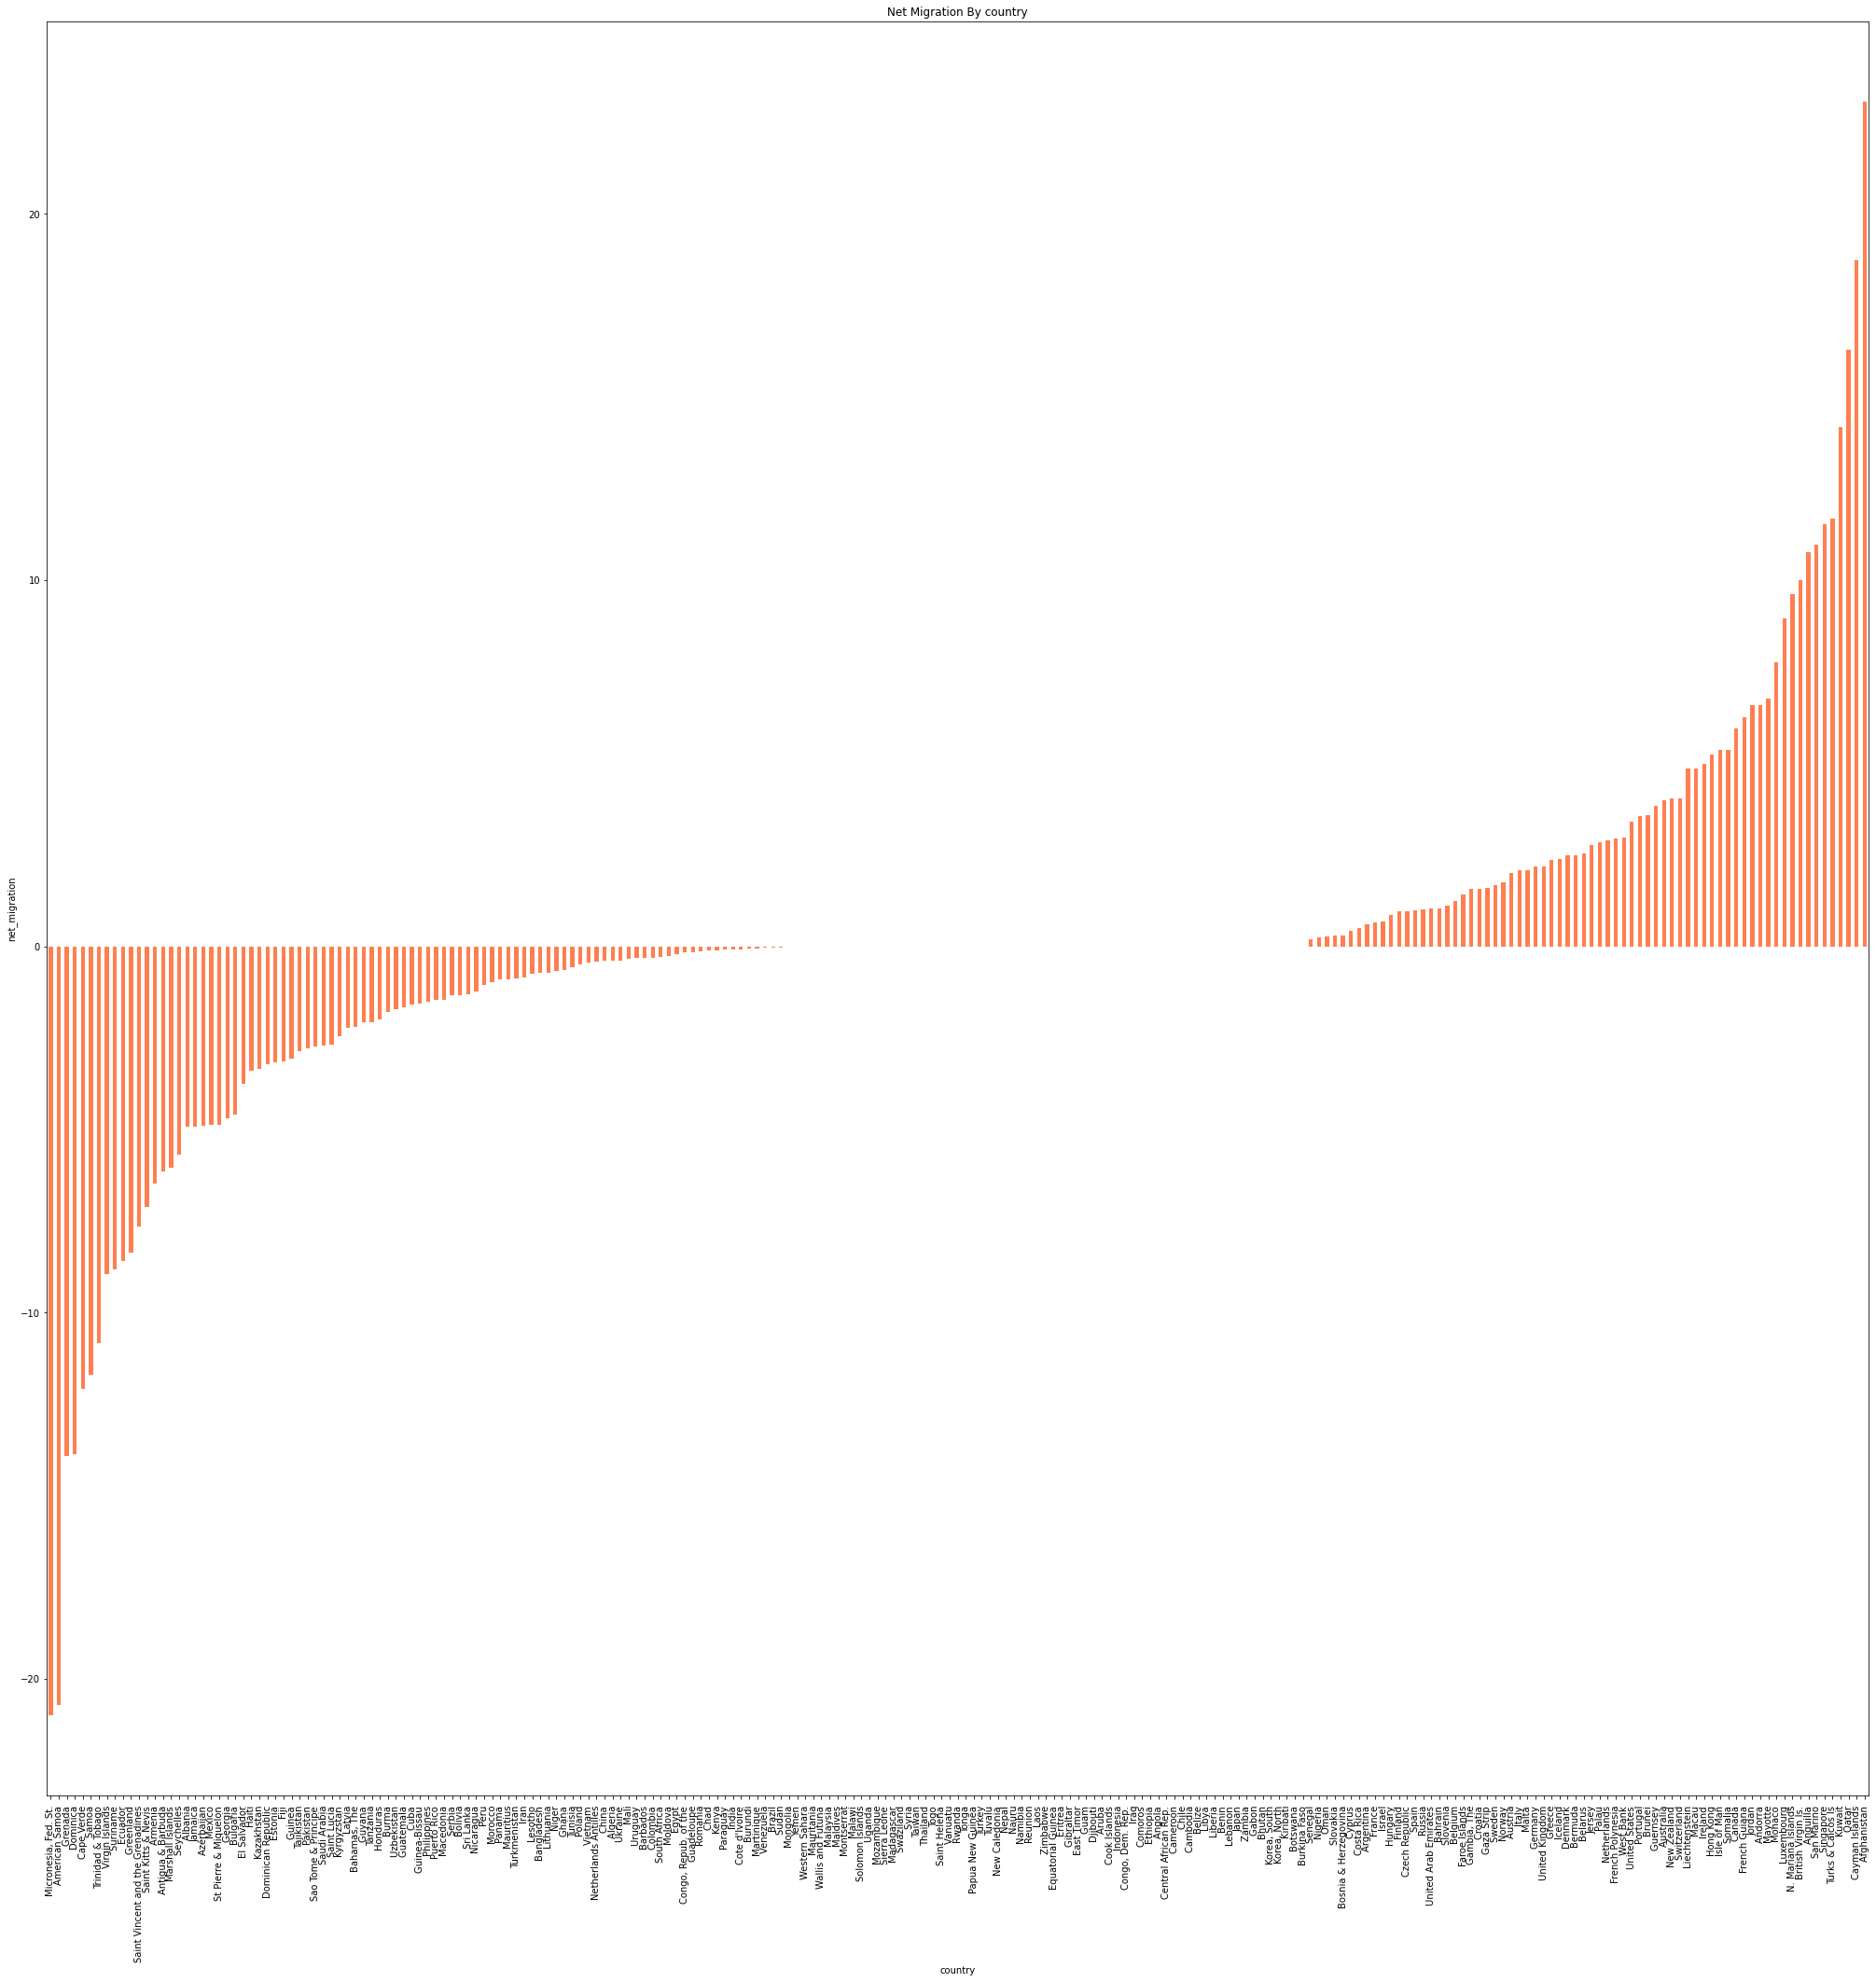

In [ ]:
##net migration analysis by country
fig = plt.figure(figsize=(35,35))
dataset.groupby('country')['net_migration'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('Net Migration By country')
plt.xlabel("country")
plt.ylabel('net_migration')
plt.show()

In [ ]:
#list of countries with the hghest net migration
NetMigrationRateData = dataset[["country", "net_migration"]]
NetMigrationRateData.sort_values(by=['net_migration'],ascending=False)

,country,net_migration
0,Afghanistan,23.06
38,Cayman Islands,18.75
166,Qatar,16.29
111,Kuwait,14.18
208,Turks & Caicos Is,11.68
...,...,...
37,Cape Verde,-12.07
56,Dominica,-13.87
81,Grenada,-13.92
3,American Samoa,-20.71


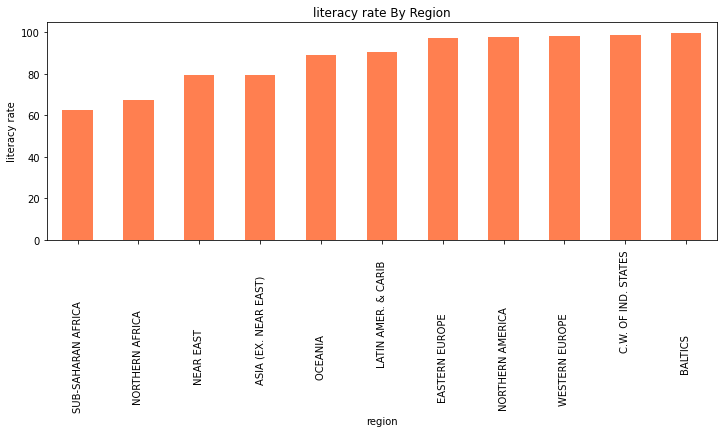

In [ ]:
#literacy rate analysis by Region

fig = plt.figure(figsize=(12, 4))
dataset.groupby('region')['literacy_rate'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('literacy rate By Region')
plt.xlabel("region")
plt.ylabel('literacy rate')
plt.show()

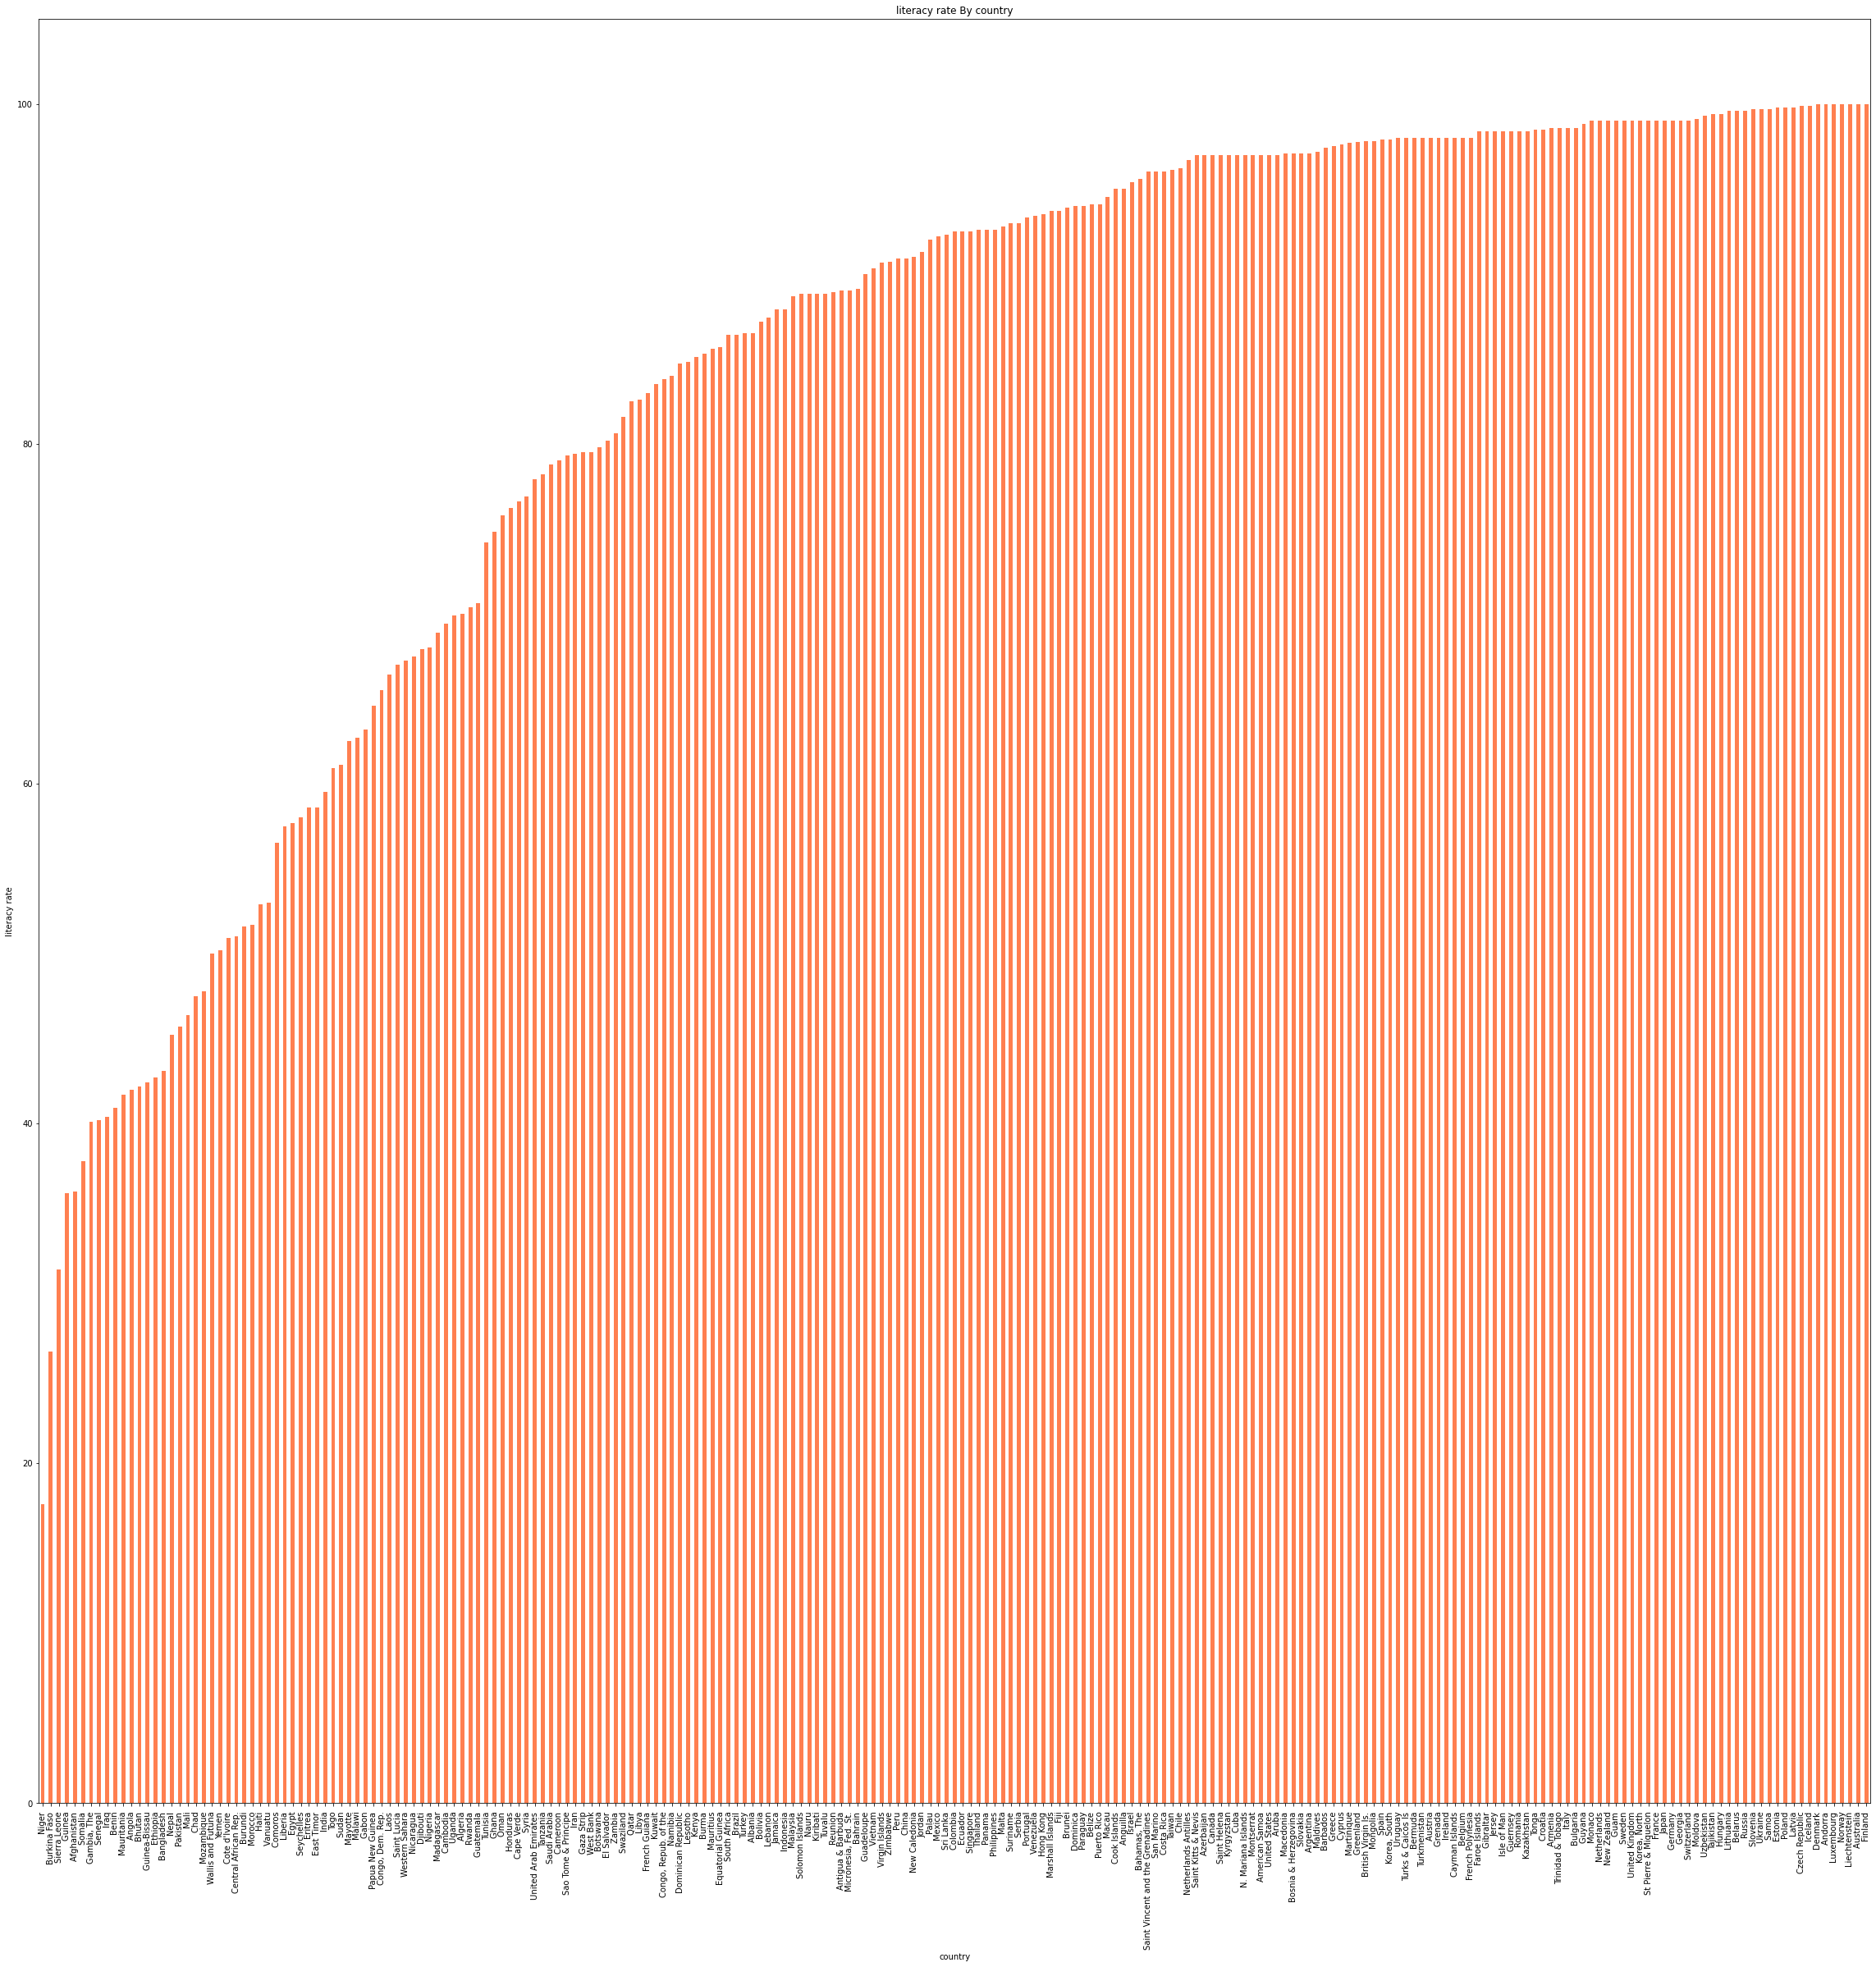

In [ ]:
##literacy analysis by country
fig = plt.figure(figsize=(40, 40))
dataset.groupby('country')['literacy_rate'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('literacy rate By country')
plt.xlabel("country")
plt.ylabel('literacy rate')
plt.show()

In [ ]:
#list of countries with the hghest literacy rate
LiteracyRateData = dataset[["country", "literacy_rate"]]
LiteracyRateData.sort_values(by=['literacy_rate'],ascending=False)

,country,literacy_rate
119,Liechtenstein,100.0
11,Australia,100.0
154,Norway,100.0
121,Luxembourg,100.0
4,Andorra,100.0
...,...,...
0,Afghanistan,36.0
86,Guinea,35.9
183,Sierra Leone,31.4
31,Burkina Faso,26.6


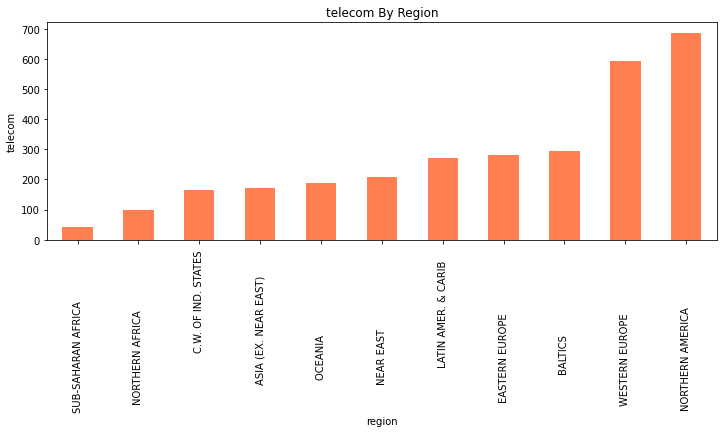

In [ ]:
#telecom analysis by Region
fig = plt.figure(figsize=(12, 4))
dataset.groupby('region')['telecom'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('telecom By Region')
plt.xlabel("region")
plt.ylabel('telecom')
plt.show()

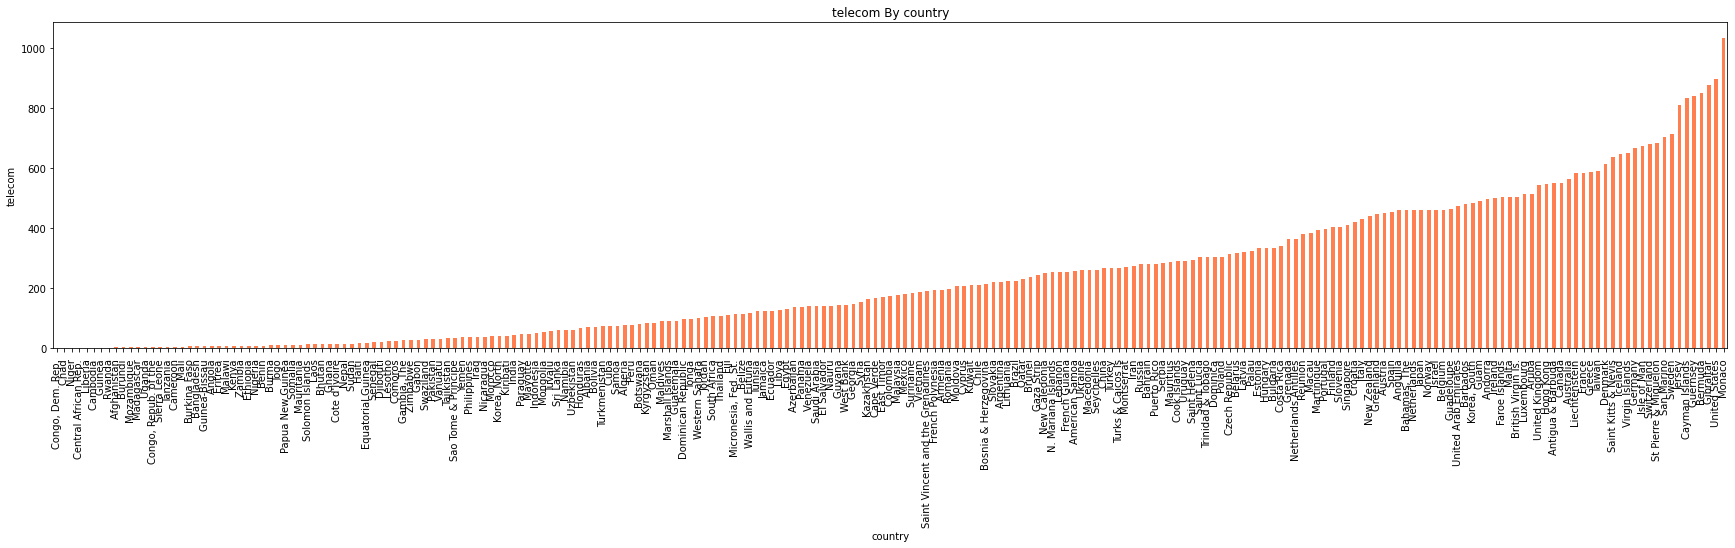

In [ ]:
#telecom analysis by Country
fig = plt.figure(figsize=(30, 6))
dataset.groupby('country')['telecom'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('telecom By country')
plt.xlabel("country")
plt.ylabel('telecom')
plt.show()

In [ ]:
#list of countries with the greatest amount of telecommunication sales
TelecomData = dataset[["country", "telecom"]]
TelecomData.sort_values(by=['telecom'],ascending=False)

,country,telecom
138,Monaco,1035.6
214,United States,898.0
78,Gibraltar,877.7
22,Bermuda,851.4
85,Guernsey,842.4
...,...,...
39,Central African Rep.,2.3
117,Liberia,2.3
151,Niger,1.9
40,Chad,1.3


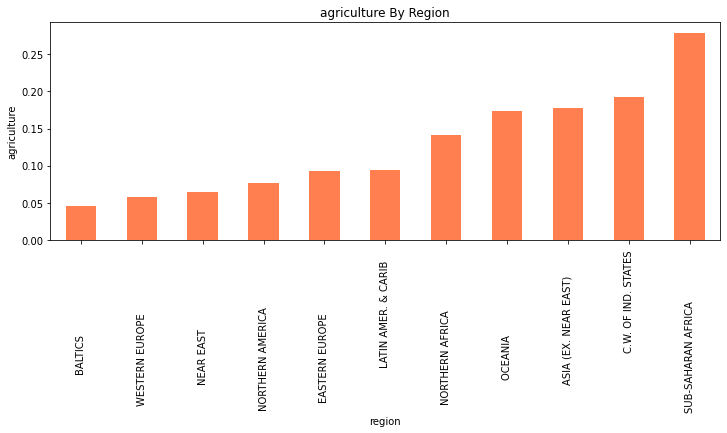

In [ ]:
#agriculture by Region
fig = plt.figure(figsize=(12, 4))
dataset.groupby('region')['agriculture'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('agriculture By Region')
plt.xlabel("region")
plt.ylabel('agriculture')
plt.show()

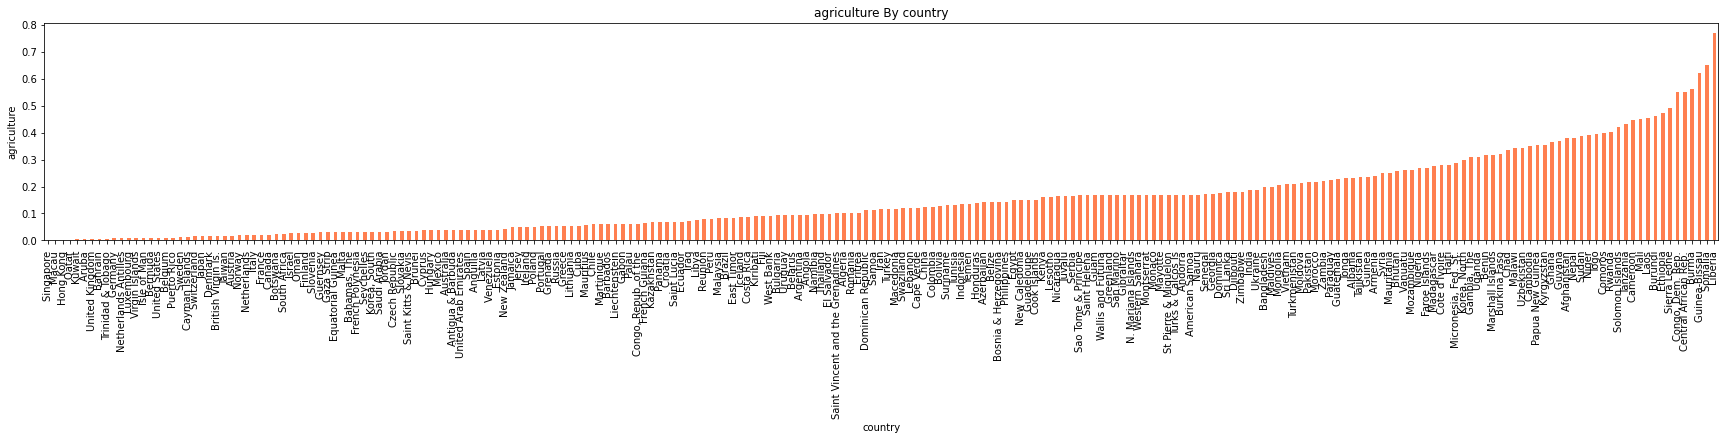

In [ ]:
#agriculture analysis by Country
fig = plt.figure(figsize=(30, 4))
dataset.groupby('country')['agriculture'].mean().sort_values().plot(kind='bar', color='coral')
plt.title('agriculture By country')
plt.xlabel("country")
plt.ylabel('agriculture')
plt.show()

In [ ]:
#list of countries with the greatest amount of agriculture
AgricultureData = dataset[["country", "agriculture"]]
AgricultureData.sort_values(by=['agriculture'],ascending=False)

,country,agriculture
117,Liberia,0.769
188,Somalia,0.650
87,Guinea-Bissau,0.620
32,Burma,0.564
39,Central African Rep.,0.550
...,...,...
10,Aruba,0.004
166,Qatar,0.002
122,Macau,0.001
91,Hong Kong,0.001


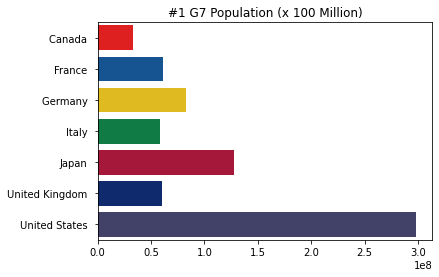

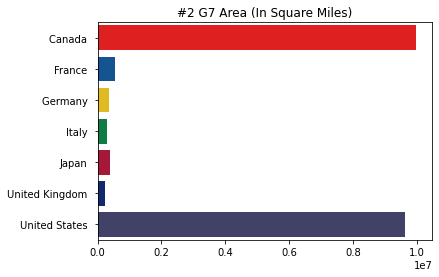

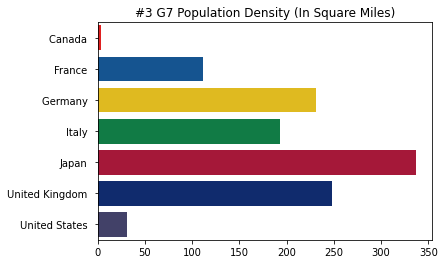

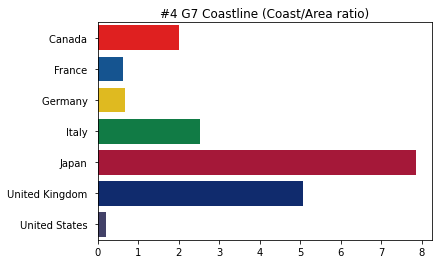

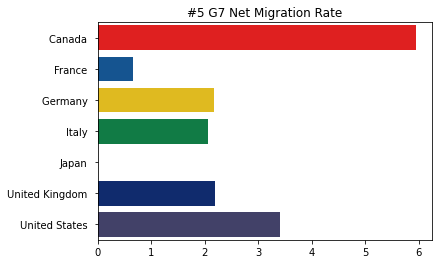

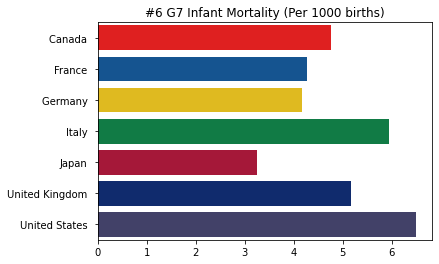

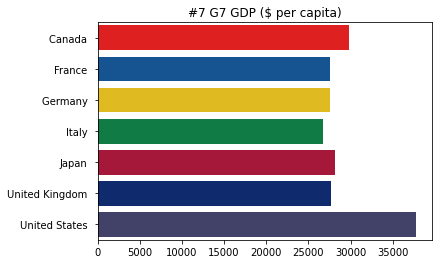

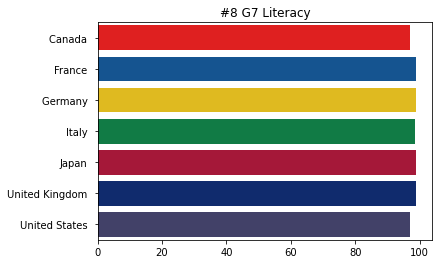

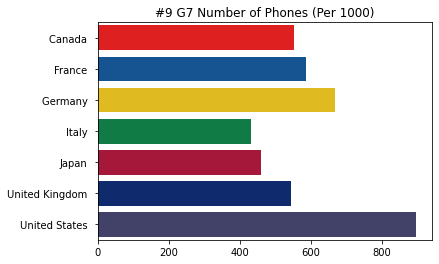

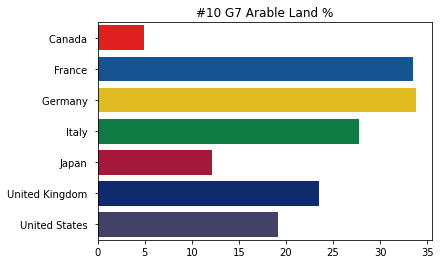

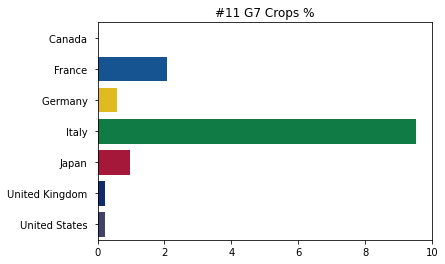

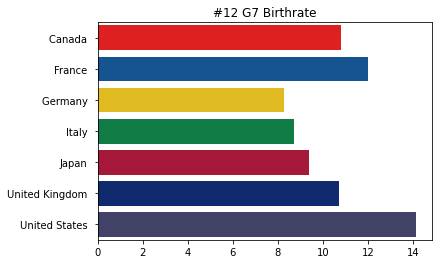

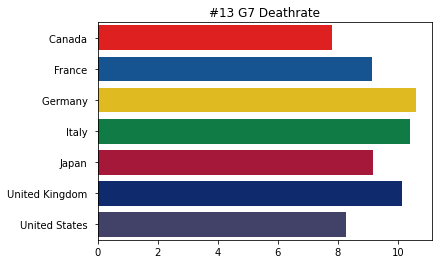

In [ ]:
#data for the G7 countries


group_seven = dataset.country.isin(["Canada ","France ","Germany ","Italy ","Japan ","United Kingdom ","United States "])
group_seven = dataset[group_seven]
def group_seven_function(y,title):
    palette = {"Canada ":"#FF0000","France ":"#0055A4","Germany ":"#FFCE00","Italy ":"#008C45","Japan ":"#BC002D","United Kingdom ":"#00247D",
               "United States ":"#3C3B6E"}
    sns.barplot(data=group_seven,y="country",x=y,palette=palette,order=["Canada ","France ","Germany ","Italy ","Japan ","United Kingdom ","United States "])
    plt.ylabel("")
    plt.xlabel("")
    plt.title(title)
    plt.show()

group_seven_dict = {"population":"#1 G7 Population (x 100 Million)","area":"#2 G7 Area (In Square Miles)","density":"#3 G7 Population Density (In Square Miles)","coastline_area_ratio":"#4 G7 Coastline (Coast/Area ratio)","net_migration":"#5 G7 Net Migration Rate", 'infant_mortality_rate':"#6 G7 Infant Mortality (Per 1000 births)", 'gdp_per_capita':"#7 G7 GDP ($ per capita)",'literacy_rate':"#8 G7 Literacy",'telecom':"#9 G7 Number of Phones (Per 1000)",'arable':"#10 G7 Arable Land %",'crops':"#11 G7 Crops %",'birthrate':"#12 G7 Birthrate",'deathrate':"#13 G7 Deathrate"}
for key,value in group_seven_dict.items():
    group_seven_function(key,value)



In [ ]:
#display data for the population of the G7 countries in decending order
PopulationData = dataset[["country", "population", "density"]]
PopulationData.sort_values(by=['population'],ascending=False)

,country,population,density
42,China,1313973713,136.9
94,India,1095351995,333.2
214,United States,298444215,31.0
95,Indonesia,245452739,127.9
27,Brazil,188078227,22.1
...,...,...,...
144,Nauru,13287,632.7
209,Tuvalu,11810,454.2
140,Montserrat,9439,92.5
171,Saint Helena,7502,18.2


In [ ]:

PopulationData[PopulationData["country"] == 'Canada '] 


,country,population,density
36,Canada,33098932,3.3


In [ ]:
PopulationData[PopulationData["country"] == 'United States '] 

,country,population,density
214,United States,298444215,31.0


In [ ]:
#adding coulumn indicaors for region and climate in numerical form
LE = LabelEncoder()
dataset['region_label'] = LE.fit_transform(dataset['region'])
dataset['climate_label'] = LE.fit_transform(dataset['climate'])
dataset.head()

,country,region,population,area,density,coastline_area_ratio,net_migration,infant_mortality_rate,gdp_per_capita,literacy_rate,...,crops,other,climate,birthrate,deathrate,agriculture,industry,service,region_label,climate_label
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380,0,1
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579,3,5
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298,6,1
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,15.00,75.00,2.0,22.46,3.27,0.170,0.030,0.800,8,3
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0.00,97.78,3.0,8.71,6.25,0.170,0.030,0.800,10,5


In [ ]:
dataset.columns

Index(['country', 'region', 'population', 'area', 'density',
       'coastline_area_ratio', 'net_migration', 'infant_mortality_rate',
       'gdp_per_capita', 'literacy_rate', 'telecom', 'arable', 'crops',
       'other', 'climate', 'birthrate', 'deathrate', 'agriculture', 'industry',
       'service', 'region_label', 'climate_label'],
      dtype='object')

In [ ]:
#all coulumns
train, test = train_test_split(dataset, test_size=0.2, shuffle=True)
training_features = ['population', 'area', 
'density','coastline_area_ratio', 
'net_migration', 'infant_mortality_rate', 'literacy_rate', 'telecom',
 'arable', 'crops','other','birthrate', 
'deathrate', 'agriculture', 'industry','service', 
'region_label', 'climate_label']

target = 'gdp_per_capita'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

In [ ]:
print(train_X.shape) 
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(181, 18)
(181,)
(46, 18)
(46,)


In [ ]:
#random forrest regression
model = RandomForestRegressor(n_estimators = 100,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)
model.fit(train_X, train_Y)
train_pred_Y = model.predict(train_X)
test_pred_Y = model.predict(test_X)

In [ ]:
#training and testing values
print('Training Score :',model.score(train_X,train_Y))
print(f'Test score : ',r2_score(test_pred_Y,test_Y))

Training Score : 0.900646731562925
Test score :  0.7021060947208606


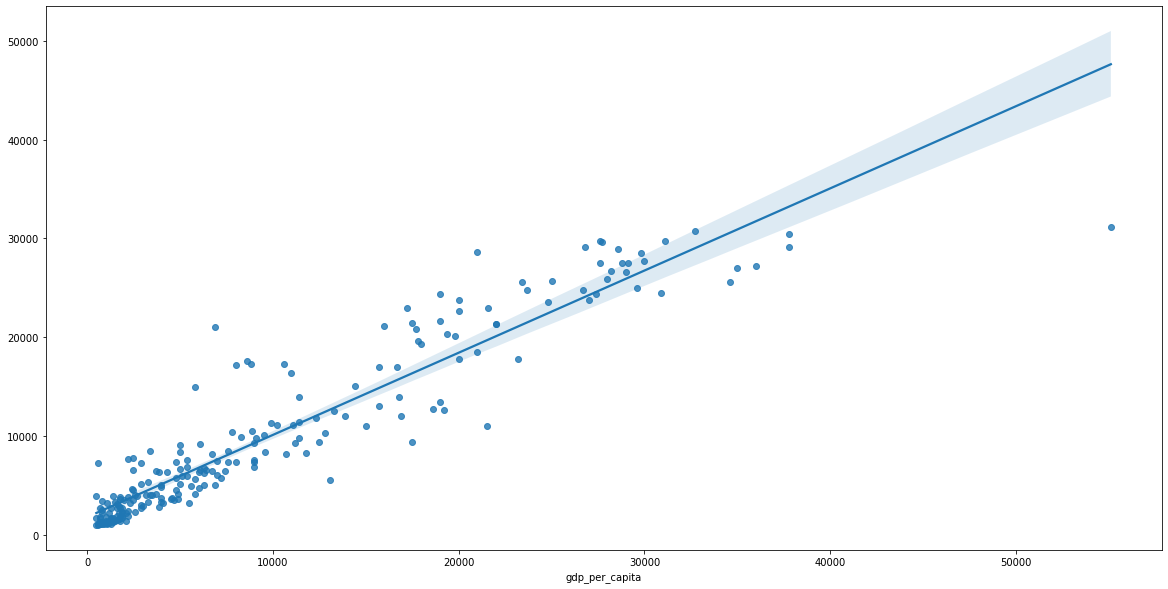

In [ ]:
#plot graph
plt.figure(figsize=(20,10))
whole=model.predict(dataset[training_features])
sns.regplot(x=dataset[target],y=whole) 

In [ ]:
dataset.columns

Index(['country', 'region', 'population', 'area', 'density',
       'coastline_area_ratio', 'net_migration', 'infant_mortality_rate',
       'gdp_per_capita', 'literacy_rate', 'telecom', 'arable', 'crops',
       'other', 'climate', 'birthrate', 'deathrate', 'agriculture', 'industry',
       'service', 'region_label', 'climate_label'],
      dtype='object')

In [ ]:
#all coulumns
train, test = train_test_split(dataset, test_size=sizeA, shuffle=True)
training_features = ['population', 'area', 
'density','coastline_area_ratio', 
'net_migration', 'infant_mortality_rate', 'literacy_rate', 'telecom',
 'arable', 'crops','other','birthrate', 
'deathrate', 'agriculture', 'industry','service', 
'region_label', 'climate_label']

target = 'gdp_per_capita'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

# Random forest model using all columns.
rgmodel = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)
rgmodel.fit(train_X, train_Y)
train_pred_Y = rgmodel.predict(train_X)
test_pred_Y = rgmodel.predict(test_X)
train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=train_Y.index)
test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=test_Y.index)

rmse_train = np.sqrt(mean_squared_error(train_pred_Y, train_Y))
msle_train = mean_squared_log_error(train_pred_Y, train_Y)
rmse_test = np.sqrt(mean_squared_error(test_pred_Y, test_Y))
msle_test = mean_squared_log_error(test_pred_Y, test_Y)

print('rmse_train:',rmse_train,'msle_train:',msle_train)
print('rmse_test:',rmse_test,'msle_test:',msle_test)

rmse_train: 2546.5301073314226 msle_train: 0.18697672798440965
rmse_test: 7123.931147720966 msle_test: 0.43340812461798456


Variance score:0.6622090219511805


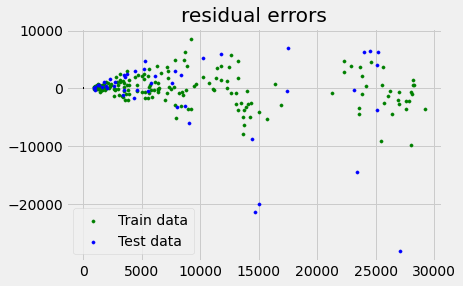

In [ ]:
reg= RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)
reg.fit(train_X, train_Y)

#variance score 1 means perfect prediction

print('Variance score:{}'.format(reg.score(test_X,test_Y)))

plt.style.use('fivethirtyeight')

plt.scatter(reg.predict(train_X), reg.predict(train_X) - train_Y,
            color = 'green', s= 10, label='Train data')

plt.scatter(reg.predict(test_X), reg.predict(test_X) - test_Y,
            color = 'blue', s= 10, label='Test data')

plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)

plt.legend(loc = 'best')

plt.title('residual errors')

plt.show()

In [ ]:
# model with only some features
train, test = train_test_split(dataset, test_size=0.2, shuffle=True)
training_features = [ 'density', 'literacy_rate', 'telecom','service','net_migration']

target = 'gdp_per_capita'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

# Random forest model with only some columns
rgmodel = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)
rgmodel.fit(train_X, train_Y)
train_pred_Y = rgmodel.predict(train_X)
test_pred_Y = rgmodel.predict(test_X)

print('\nsome features, No scaling:')
print('MAE:', metrics.mean_absolute_error(test_Y, test_pred_Y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_Y, test_pred_Y)))
print('Accuracy: ', metrics.r2_score(test_Y, test_pred_Y))



some features, No scaling:
MAE: 2610.337007673643
RMSE: 5182.26172944181
Accuracy:  0.7416079210437421


Variance score:0.7416079210437421


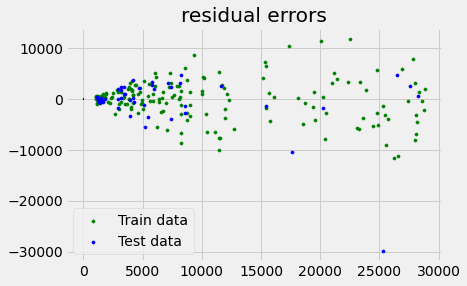

In [ ]:
reg= RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)
reg.fit(train_X, train_Y)

#variance score 1 means perfect prediction

print('Variance score:{}'.format(reg.score(test_X,test_Y)))

plt.style.use('fivethirtyeight')

plt.scatter(reg.predict(train_X), reg.predict(train_X) - train_Y,
            color = 'green', s= 10, label='Train data')

plt.scatter(reg.predict(test_X), reg.predict(test_X) - test_Y,
            color = 'blue', s= 10, label='Test data')

plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)

plt.legend(loc = 'best')

plt.title('residual errors')

plt.show()

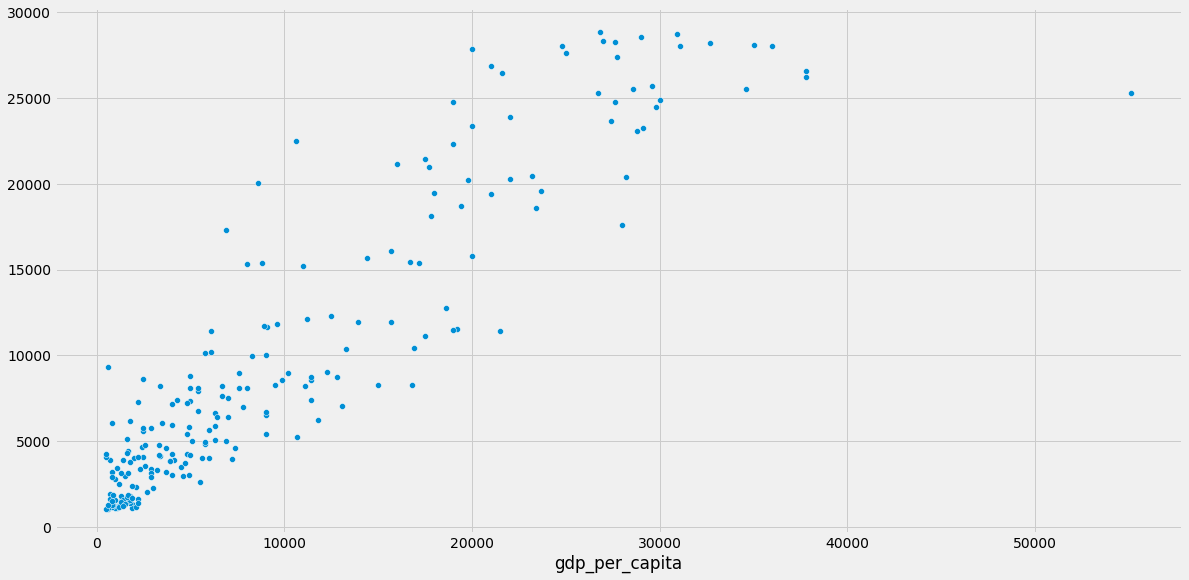

In [ ]:
#plot the scatterplot
plt.figure(figsize=(18,9))
whole=rgmodel.predict(dataset[training_features])
sns.scatterplot(x=dataset[target],y=whole) 